In [1]:
import csv
import pandas
import requests
from pprint import pprint
from vega import VegaLite
from collections import Counter, defaultdict

In [2]:
DATA = '../data/didascalies.csv'
GROUPES = 'https://www.nosdeputes.fr/organismes/groupe/json'
groupes = {o["organisme"]["acronyme"]: o["organisme"] for o in requests.get(GROUPES).json()['organismes']}

In [3]:
with open(DATA, 'r') as f:
    data = list(csv.DictReader(f))
df = pandas.read_table('../data/didascalies.csv', ',')
df.head()

,id,seance_id,date,moment,type,titre,titre_complet,timestamp,intervention,nb_mots,nom,parlementaire,sexe,parlementaire_groupe_acronyme,fonction,source,didascalie,groups,parlementaire_groupe_norme,ton
0,14,1,2017-06-27,15:00,loi,allocution du doyen d'âge,allocution du doyen d'âge,170,<p>Monsieur le secrétaire d'État chargé des re...,636,NaN,Bernard Brochand,H,NI,"président, doyen d'âge",http://www.assemblee-nationale.fr/15/cri/2016-...,Applaudissements,NaN,NI,neutre
1,17,1,2017-06-27,15:00,loi,Élection du président de l'assemblée nationale,Élection du président de l'assemblée nationale,220,"<p>L'ordre du jour appelle, conformément à l'a...",140,NaN,Bernard Brochand,H,NI,"président, doyen d'âge",http://www.assemblee-nationale.fr/15/cri/2016-...,Il est procédé au tirage au sort,NaN,NI,neutre
2,19,1,2017-06-27,15:00,loi,Élection du président de l'assemblée nationale,Élection du président de l'assemblée nationale,250,<p>Sont désignés scrutateurs titulaires : M. B...,51,NaN,Bernard Brochand,H,NI,"président, doyen d'âge",http://www.assemblee-nationale.fr/15/cri/2016-...,Il est procédé au tirage au sort,NaN,NI,neutre
3,26,1,2017-06-27,15:00,loi,Élection du président de l'assemblée nationale,Élection du président de l'assemblée nationale,350,<p>La séance est reprise.</p><p>Mes chers coll...,63,NaN,Bernard Brochand,H,NI,"président, doyen d'âge",http://www.assemblee-nationale.fr/15/cri/2016-...,Mmes et MM. les députés et M. le secrétaire d'...,LREM|MODEM|LR|LFI|UAI|NG|GDR|NI,NI,positif
4,28,1,2017-06-27,15:00,loi,Élection du président de l'assemblée nationale,Élection du président de l'assemblée nationale,370,<p>M. Jean-Charles Taugourdeau : 94 voix</p>,6,NaN,Bernard Brochand,H,NI,"président, doyen d'âge",http://www.assemblee-nationale.fr/15/cri/2016-...,Applaudissements,NaN,NI,neutre


In [4]:
def matrix(reference, filtr=None, normalize_groupes=False, normalize=False, nodiagonal=False):
    C = Counter()
    TOT1 = Counter()
    TOT2 = Counter()
    for r in data:
        key = r[reference]
        if reference == "parlementaire":
            key += " (%s)" % r["parlementaire_groupe_norme"]
        if r["groups"] and r[reference] != "NULL" and (not filtr or re.search(filtr, r["didascalie"], re.I)):
            for g in r["groups"].split("|"):
                TOT1[key] += 1
                TOT2[g] += 1
                C[(key, g)] += 1
    rows = []
    for ((g1, g2), n) in C.items():
        if (nodiagonal and g1 == g2):
            total = None
        elif normalize:
            total = n / TOT1[g1]
        elif normalize_groupes:
            total = n / TOT2[g2]
        else:
            total = n
        rows.append({
            "orateur": g1,
            "order_ora": groupes[g1]["order"] if reference == "parlementaire_groupe_norme" else 0,
            "didascalie": g2,
            "order_did": groupes[g2]["order"],
            "total": total
        })
    #pprint(rows)
    return VegaLite({
      "mark": "rect",
      "encoding": {
        "y": {"field": "orateur", "type": "nominal", "sort": {"op": "mean", "field": "order_ora"}},
        "x": {"field": "didascalie", "type": "nominal", "sort": {"op": "mean", "field": "order_did"}},
        "color": {"field": "total", "type": "quantitative", "scale": {"type": "bib-ordinal"}},
        "tooltip": {"field": "total", "type": "quantitative"}
      }
    }, rows)

def groupes_groupes(filtr=None, normalize_groupes=False, normalize=False, nodiagonal=False):
    return matrix("parlementaire_groupe_norme", filtr, normalize_groupes, normalize, nodiagonal)

def groupes_sexe(filtr=None, normalize_groupes=False, normalize=False):
    return matrix("sexe", filtr, normalize_groupes, normalize)

def groupes_ministres(filtr=None, normalize_groupes=False, normalize=False):
    return matrix("nom", filtr, normalize_groupes, normalize)

def groupes_deputes(filtr=None, normalize_groupes=False, normalize=False):
    return matrix("parlementaire", filtr, normalize_groupes, normalize)

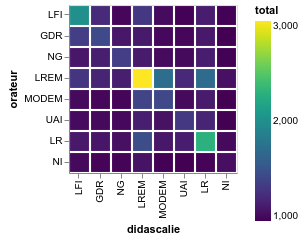

In [5]:
groupes_groupes()

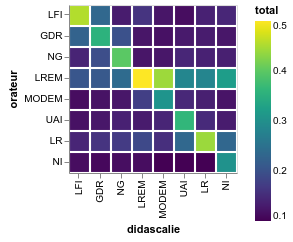

In [6]:
groupes_groupes(normalize_groupes=True)

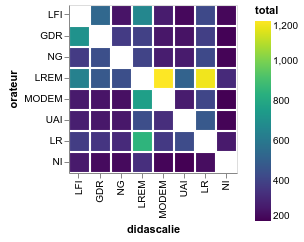

In [7]:
groupes_groupes(nodiagonal=True)

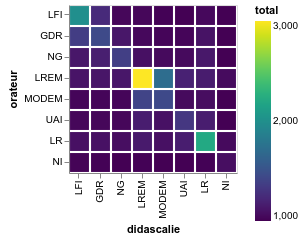

In [8]:
groupes_groupes("applaud")

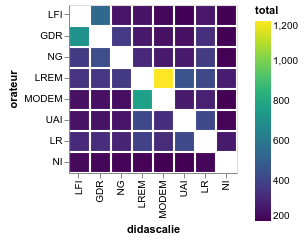

In [9]:
groupes_groupes("applaud", nodiagonal=True)

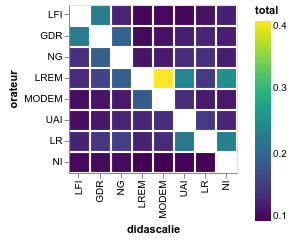

In [10]:
groupes_groupes("applaud", nodiagonal=True, normalize_groupes=True)

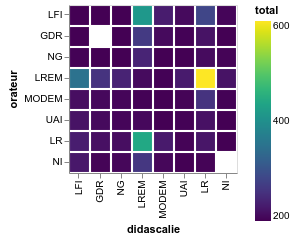

In [11]:
groupes_groupes("exclam")

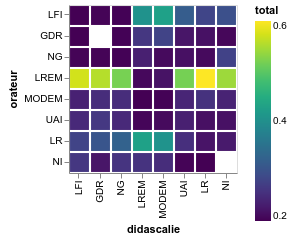

In [12]:
groupes_groupes("exclam", normalize_groupes=True)

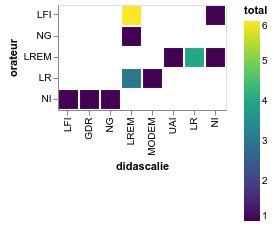

In [13]:
groupes_groupes("pupitre")

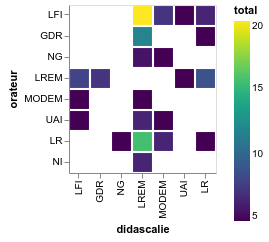

In [14]:
groupes_groupes("murmure")

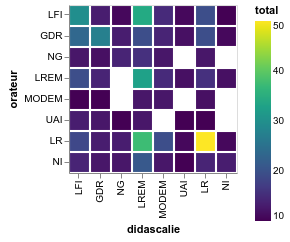

In [15]:
groupes_groupes("rires")

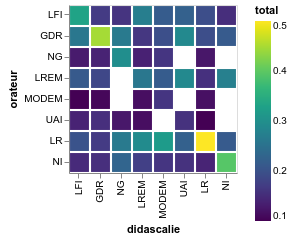

In [16]:
groupes_groupes("rires", normalize_groupes=True)

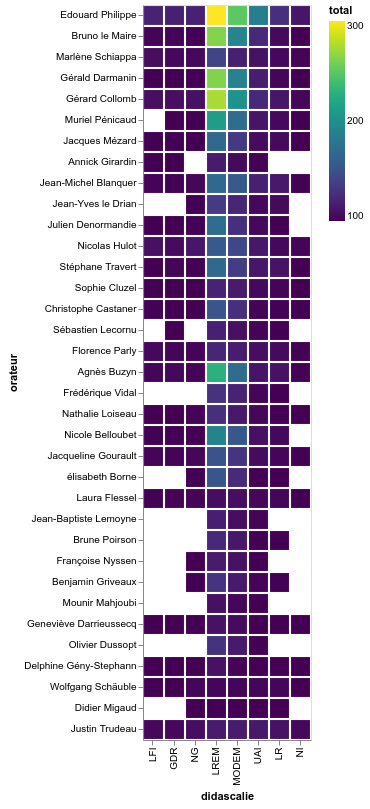

In [17]:
groupes_ministres("applaud")

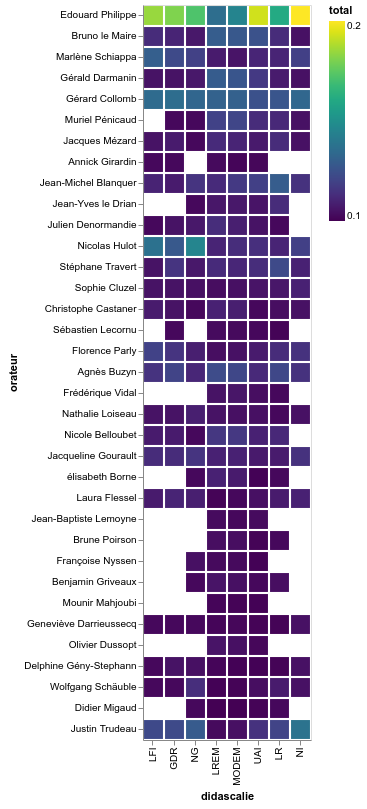

In [18]:
groupes_ministres("applaud", normalize_groupes=True)

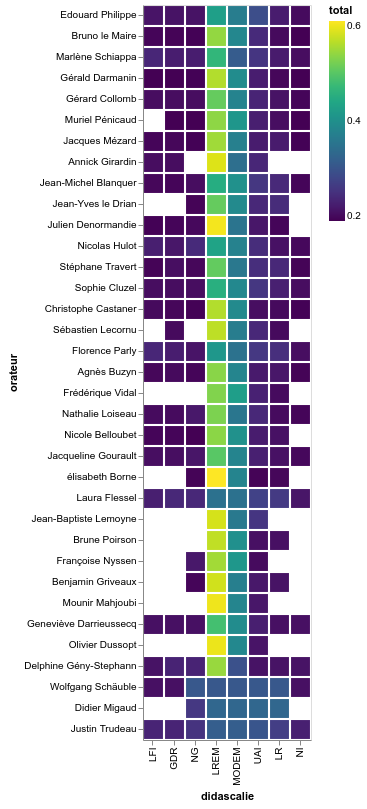

In [19]:
groupes_ministres("applaud", normalize=True)

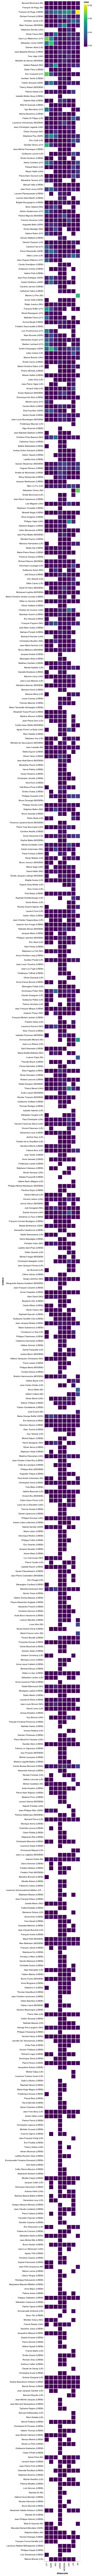

In [20]:
groupes_deputes("applaud", normalize_groupes=True)

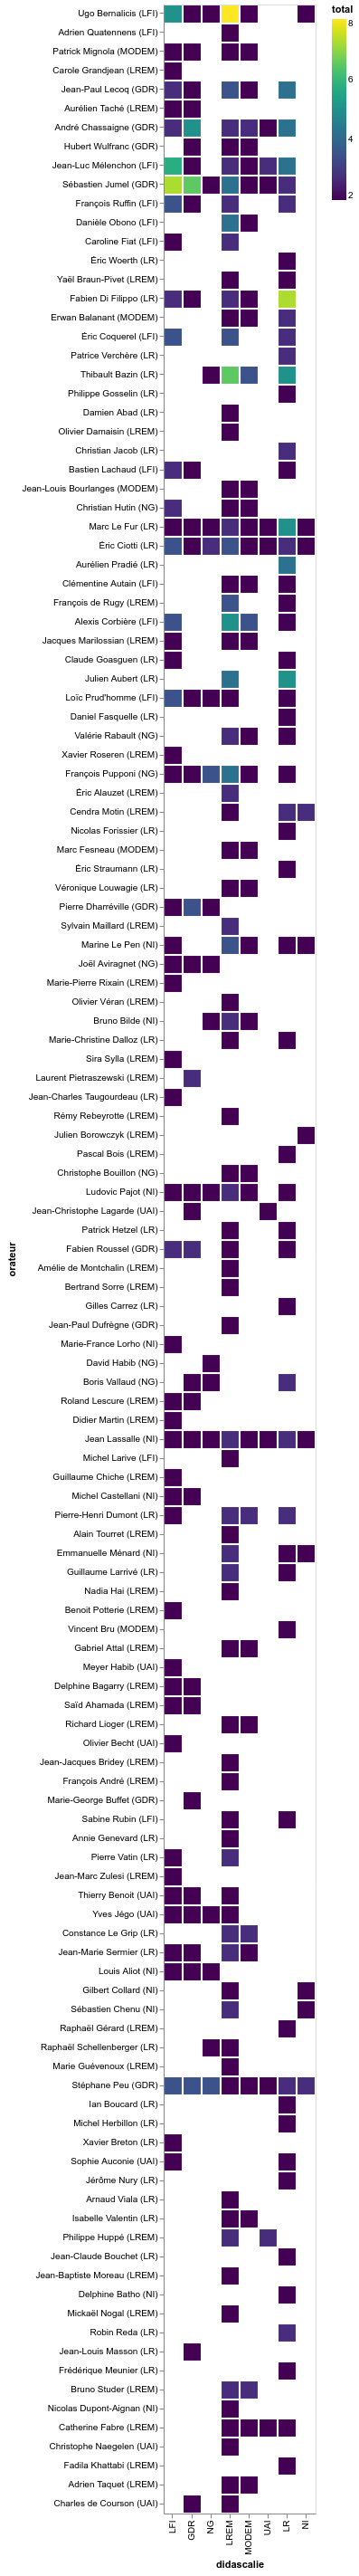

In [21]:
groupes_deputes("rires")